## 1

In [3]:
import pandas as pd
labeled_df = pd.read_csv("labeled_posts_full.csv")

/tmp/ipykernel_347/2898943466.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  labeled_df = pd.read_csv("labeled_posts_full.csv")


In [4]:
economic = labeled_df[labeled_df["is_economic"] == True][["message_id", "id_channel", "message", "viral_final", "is_economic", "topic", "confidence", "reason"]]


In [5]:
economic["topic"] = economic["topic"].replace({
    "Сырьевые рын рынки": "Сырьевые рынки",
    "Сырьевые рынры": "Сырьевые рынки",
})

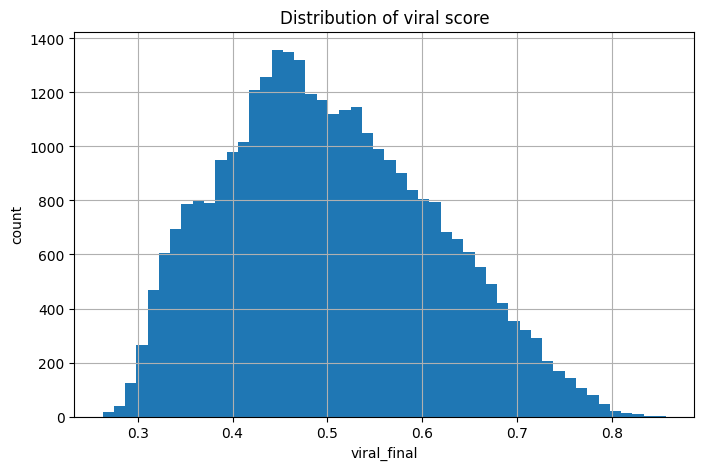

In [6]:
import matplotlib.pyplot as plt


data = economic.sort_values("viral_final")["viral_final"]

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50)
plt.xlabel("viral_final")
plt.ylabel("count")
plt.title("Distribution of viral score")
plt.grid(True)
plt.show()

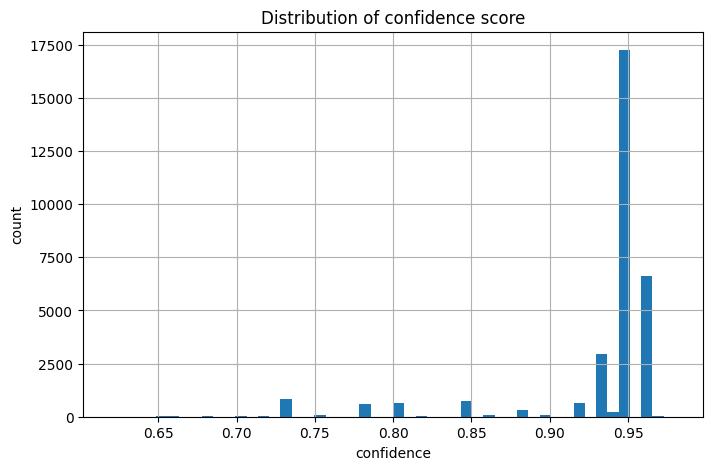

In [7]:
import matplotlib.pyplot as plt


data = economic.sort_values("confidence")["confidence"]

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50)
plt.xlabel("confidence")
plt.ylabel("count")
plt.title("Distribution of confidence score")
plt.grid(True)
plt.show()

In [8]:
import numpy as np
import pandas as pd

def stratified_sample_topic_quantile_bands(
    df: pd.DataFrame,
    N: int,
    score_col: str = "viral_final",
    topic_col: str = "topic",
    bands=None,
    seed: int = 42,
    replace_if_needed: bool = True,
):
    rng = np.random.default_rng(seed)
    d = df.copy()
    d = d[d[score_col].notna() & d[topic_col].notna()].copy()

    if bands is None:
        bands = [
            (0.90, 1.00, 0.30),
            (0.75, 0.90, 0.20),
            (0.50, 0.75, 0.20),
            (0.25, 0.50, 0.20),
            (0.00, 0.25, 0.10),
        ]

    # нормализуем доли на всякий случай
    total_share = sum(b[2] for b in bands)
    bands = [(a, b, s / total_share) for a, b, s in bands]

    # посчитаем реальные пороги значений по score_col
    qs = sorted(set([x for band in bands for x in band[:2]]))
    qvals = d[score_col].quantile(qs).to_dict()

    # присвоим band_id
    band_edges = []
    band_labels = []
    for i, (qlo, qhi, _) in enumerate(bands):
        lo = qvals[qlo]
        hi = qvals[qhi]
        band_edges.append((lo, hi, i))
        band_labels.append(f"q{int(qlo*100):02d}-q{int(qhi*100):02d}")

    def assign_band(x):
        for (lo, hi, i), (_, qhi, _) in zip(band_edges, bands):
            # правую границу включаем только у самого верхнего бина
            is_top = (qhi == 1.0)
            if (x >= lo) and (x <= hi if is_top else x < hi):
                return i
        # если из-за дублей/краёв не попали — отправим в самый нижний
        return 0

    d["band_id"] = d[score_col].apply(assign_band)

    topics = sorted(d[topic_col].unique())
    n_topics = len(topics)
    base = N // n_topics
    rem = N % n_topics
    topic_targets = {t: base + (1 if i < rem else 0) for i, t in enumerate(topics)}

    shares = np.array([s for (_, _, s) in bands], dtype=float)

    out = []
    for t in topics:
        td = d[d[topic_col] == t]
        tN = topic_targets[t]

        # сколько нужно на каждый band внутри topic
        counts = np.floor(tN * shares).astype(int)
        residual = tN - counts.sum()
        if residual > 0:
            frac = (tN * shares) - np.floor(tN * shares)
            for idx in np.argsort(-frac)[:residual]:
                counts[idx] += 1

        picked_idx = []

        deficits = 0
        for band_i, need in enumerate(counts):
            need = int(need)
            if need == 0:
                continue
            strata = td[td["band_id"] == band_i]
            if len(strata) >= need:
                picked_idx.extend(
                    strata.sample(n=need, replace=False, random_state=int(rng.integers(1e9))).index
                )
            else:
                if len(strata) > 0:
                    picked_idx.extend(
                        strata.sample(n=need, replace=replace_if_needed, random_state=int(rng.integers(1e9))).index
                        if replace_if_needed else strata.index
                    )
                    if not replace_if_needed and len(strata) < need:
                        deficits += (need - len(strata))
                else:
                    deficits += need

        cur = d.loc[picked_idx]
        if len(cur) < tN:
            extra = td.drop(index=set(picked_idx), errors="ignore")
            if len(extra) == 0 and replace_if_needed:
                extra_pick = td.sample(n=(tN - len(cur)), replace=True, random_state=int(rng.integers(1e9)))
            else:
                extra_pick = extra.sample(n=min(tN - len(cur), len(extra)), replace=False,
                                          random_state=int(rng.integers(1e9)))
                if len(extra_pick) < (tN - len(cur)) and replace_if_needed:
                    extra2 = td.sample(n=(tN - len(cur) - len(extra_pick)), replace=True,
                                       random_state=int(rng.integers(1e9)))
                    extra_pick = pd.concat([extra_pick, extra2])
            cur = pd.concat([cur, extra_pick], ignore_index=False)

        out.append(cur)

    sample_df = pd.concat(out, ignore_index=True)
    if len(sample_df) > N:
        sample_df = sample_df.sample(n=N, random_state=int(rng.integers(1e9))).reset_index(drop=True)

    sample_df["band_label"] = sample_df["band_id"].map({i: band_labels[i] for i in range(len(band_labels))})

    return sample_df


In [9]:
bands = [
    (0.90, 1.00, 0.30), 
    (0.75, 0.90, 0.20),  
    (0.50, 0.75, 0.20),
    (0.25, 0.50, 0.20),
    (0.00, 0.25, 0.10),
]

sample = stratified_sample_topic_quantile_bands(
    economic, N=200, bands=bands, replace_if_needed=True, seed=42
)

display(sample["topic"].value_counts())
sample["band_label"].value_counts(normalize=True).sort_index()


topic
Валютный рынок                            23
Государственная экономическая политика    23
Другое                                    22
Корпоративные финансы                     22
Макроэкономика                            22
Международная торговля                    22
Рынки капитала                            22
Санкции и геополитика                     22
Сырьевые рынки                            22
Name: count, dtype: int64

band_label
q00-q25     0.090
q25-q50     0.180
q50-q75     0.190
q75-q90     0.225
q90-q100    0.315
Name: proportion, dtype: float64

In [10]:
sample = pd.read_csv("sample.csv")

In [11]:
! pip install openpyxl
sample_done = pd.read_excel("golden_set_markup_results.xlsx")

Looking in indexes: https://artifactory.tcsbank.ru/artifactory/api/pypi/python-all/simple
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 17.9 MB/s eta 0:00:00

[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: python3.10 -m pip install --upgrade pip


In [12]:
sample_done.shape

(200, 18)

In [13]:
sample_done.head()

,message_id,message,topic,reason,login1,Экономический эффект (1),Информационный резонанс (1),Правильность определения темы (1),Экономический нарратив (1),Сила нарратива (1),Комментарий (1),login2,Экономический эффект (2),Информационный резонанс (2),Правильность определения темы (2),Экономический нарратив (2),Сила нарратива (2),Комментарий (2)
0,8c497c96-be46-4bb4-888f-25e40d20debb,#POSI \nГК Позитив — лидер в рейтинге покупок ...,Рынки капитала,Новость описывает активные покупки акций и изм...,DariaLyutova,Нейтрально,Низкий,Согласен,Нет,Низкая,"Мне кажется, что тут надо очень хорошо понимат...",bruhwalkk,Нейтрально,Низкий,Согласен,Нет,Низкая,NaN
1,63c159f3-4205-4477-bb06-e00c0bde9187,⚡️Россельхознадзор опроверг запрет на ввоз ман...,Международная торговля,Новость сообщает о заявленном запрете (и его о...,DariaLyutova,Слабый позитив,Низкий,Согласен,Нет,Низкая,NaN,bruhwalkk,Слабый позитив,Средний,Согласен,Нет,Низкая,NaN
2,e189e8c9-28c2-4160-92e2-fc929057f2cc,Корпоративные бонды с доходностью 20-21%+ — се...,Рынки капитала,"Текст посвящён корпоративным облигациям, их до...",DariaLyutova,Нейтрально,Низкий,Согласен,Нет,Низкая,"Кажется, что корпорации обычному человеку не т...",bruhwalkk,Нейтрально,Средний,Согласен,Да,Средняя,NaN
3,db2e74c1-fefa-4333-823c-6e0a527e87a0,#MTLR\n🪨 Мечел в 2025г может сократить отгрузк...,Корпоративные финансы,Новость описывает финансовые решения Mechel: с...,DariaLyutova,Нейтрально,Низкий,Согласен,Нет,Низкая,"Вообще не понимаю, о чем новость и как она на ...",bruhwalkk,Слабый негатив,Средний,Согласен,Нет,Низкая,NaN
4,031d93c6-89f0-426a-ada0-9f6f4174f4b7,Россия вошла в топ-5 стран по оттоку миллионер...,Макроэкономика,Новость сообщает о масштабном оттоке миллионер...,DariaLyutova,Слабый негатив,Средний,Согласен,Да,Средняя,"Не у верена, что правильно оцениваю силу нарра...",bruhwalkk,Слабый негатив,Высокий,Частично согласен,Да,Средняя,NaN


In [14]:
sample.head()

,Unnamed: 0,message_id,id_channel,message,viral_final,is_economic,topic,confidence,reason,band_id,band_label
0,0,b1c20629-e35e-4e14-a3ce-388db1e068aa,6,"Курс рубля к доллару сейчас переоценен, учитыв...",0.665697,True,Валютный рынок,0.95,Текст обсуждает курс рубля к доллару и упомина...,0,q90-q100
1,1,c7a50032-0e6b-457d-bead-ab9dc39f0b5b,1,"⚡️Доллар — 113 рублей на бирже, евро — 119 рублей",0.754652,True,Валютный рынок,0.96,Текст сообщает текущие курсы валют (доллар и е...,0,q90-q100
2,2,42880f60-6d36-4397-a8bb-b254d52da0b3,2,#Курс #MOEX\nБКС приостанавливает возможность ...,0.657834,True,Валютный рынок,0.95,Новость описывает приостановку вывода и ввода ...,0,q90-q100
3,3,f618a168-d21e-41e1-921e-1c8bb69c2122,18,Сильный рубль как предвестник слабой экономики...,0.660161,True,Валютный рынок,0.95,"Текст подробно анализирует укрепление рубля, с...",0,q90-q100
4,4,dfcb95df-3032-4fab-a7de-068c8d3e6776,18,Нехватка юаней у российских банков побила новы...,0.665050,True,Валютный рынок,0.96,Новость описывает рост ставок по кредитам в юа...,0,q90-q100


In [15]:

# Присоединение колонок
sample_done = sample_done.merge(sample[['message_id', 'id_channel', 'viral_final', 'is_economic', 'confidence', 'band_id', 'band_label']], on='message_id', how='left')


In [16]:
sample_done.head()

,message_id,message,topic,reason,login1,Экономический эффект (1),Информационный резонанс (1),Правильность определения темы (1),Экономический нарратив (1),Сила нарратива (1),...,Правильность определения темы (2),Экономический нарратив (2),Сила нарратива (2),Комментарий (2),id_channel,viral_final,is_economic,confidence,band_id,band_label
0,8c497c96-be46-4bb4-888f-25e40d20debb,#POSI \nГК Позитив — лидер в рейтинге покупок ...,Рынки капитала,Новость описывает активные покупки акций и изм...,DariaLyutova,Нейтрально,Низкий,Согласен,Нет,Низкая,...,Согласен,Нет,Низкая,NaN,2,0.440763,True,0.96,3,q25-q50
1,63c159f3-4205-4477-bb06-e00c0bde9187,⚡️Россельхознадзор опроверг запрет на ввоз ман...,Международная торговля,Новость сообщает о заявленном запрете (и его о...,DariaLyutova,Слабый позитив,Низкий,Согласен,Нет,Низкая,...,Согласен,Нет,Низкая,NaN,1,0.651092,True,0.93,1,q75-q90
2,e189e8c9-28c2-4160-92e2-fc929057f2cc,Корпоративные бонды с доходностью 20-21%+ — се...,Рынки капитала,"Текст посвящён корпоративным облигациям, их до...",DariaLyutova,Нейтрально,Низкий,Согласен,Нет,Низкая,...,Согласен,Да,Средняя,NaN,2,0.676079,True,0.95,0,q90-q100
3,db2e74c1-fefa-4333-823c-6e0a527e87a0,#MTLR\n🪨 Мечел в 2025г может сократить отгрузк...,Корпоративные финансы,Новость описывает финансовые решения Mechel: с...,DariaLyutova,Нейтрально,Низкий,Согласен,Нет,Низкая,...,Согласен,Нет,Низкая,NaN,2,0.544580,True,0.96,2,q50-q75
4,031d93c6-89f0-426a-ada0-9f6f4174f4b7,Россия вошла в топ-5 стран по оттоку миллионер...,Макроэкономика,Новость сообщает о масштабном оттоке миллионер...,DariaLyutova,Слабый негатив,Средний,Согласен,Да,Средняя,...,Частично согласен,Да,Средняя,NaN,18,0.636313,True,0.93,1,q75-q90


In [17]:
import pandas as pd

resonance_mapping = {'Низкий': 1, 'Средний': 2, 'Высокий': 3}
narrative_mapping = {'Да': 1, 'Нет': 0}

sample_done['Информационный резонанс (1)_num'] = sample_done['Информационный резонанс (1)'].map(resonance_mapping)
sample_done['Информационный резонанс (2)_num'] = sample_done['Информационный резонанс (2)'].map(resonance_mapping)

# Удаляем строки с NaN значениями в колонках viral_final и Информационный резонанс (1) и (2)
sample_done_ = sample_done.dropna(subset=['Информационный резонанс (1)_num', 'Информационный резонанс (2)_num'])

# Рассчитываем корреляцию между viral_final и Информационным резонансом (1) и (2)
correlation_1 = sample_done_[['viral_final', 'Информационный резонанс (1)_num']].corr().iloc[0, 1]
correlation_2 = sample_done_[['viral_final', 'Информационный резонанс (2)_num']].corr().iloc[0, 1]

# Выводим результат
print(f"Корреляция между viral_final и Информационный резонанс (1): {correlation_1}")
print(f"Корреляция между viral_final и Информационный резонанс (2): {correlation_2}")


Корреляция между viral_final и Информационный резонанс (1): -0.0002166338409647294
Корреляция между viral_final и Информационный резонанс (2): 0.16674674487080812


In [18]:
narrative_mapping = {'Да': 1, 'Нет': 0}

sample_done['Экономический нарратив (1)_num'] = sample_done['Экономический нарратив (1)'].map(narrative_mapping)
sample_done['Экономический нарратив (2)_num'] = sample_done['Экономический нарратив (2)'].map(narrative_mapping)

sample_done_ = sample_done.dropna(subset=['Экономический нарратив (1)_num', 'Экономический нарратив (2)_num'])

# Рассчитываем корреляцию между viral_final и Информационным резонансом (1) и (2)
correlation_1 = sample_done_[['viral_final', 'Экономический нарратив (1)_num']].corr().iloc[0, 1]
correlation_2 = sample_done_[['viral_final', 'Экономический нарратив (2)_num']].corr().iloc[0, 1]

# Выводим результат
print(f"Корреляция между viral_final и 'Экономический нарратив (1): {correlation_1}")
print(f"Корреляция между viral_final и 'Экономический нарратив (2): {correlation_2}")


Корреляция между viral_final и 'Экономический нарратив (1): 0.12320434347476576
Корреляция между viral_final и 'Экономический нарратив (2): 0.24250774504974348


In [19]:
# Создаем первую таблицу для значений (1)
sample_done_1 = sample_done[['message_id', 'message', 'topic', 'reason', 'login1', 
                             'Экономический эффект (1)', 'Информационный резонанс (1)', 
                             'Правильность определения темы (1)', 'Экономический нарратив (1)', 
                             'Сила нарратива (1)', 'id_channel', 'viral_final', 'is_economic', 
                             'confidence', 'band_id', 'band_label']]

# Создаем вторую таблицу для значений (2)
sample_done_2 = sample_done[['message_id', 'message', 'topic', 'reason', 'login1', 
                             'Экономический эффект (2)', 'Информационный резонанс (2)', 
                             'Правильность определения темы (2)', 'Экономический нарратив (2)', 
                             'Сила нарратива (2)', 'id_channel', 'viral_final', 'is_economic', 
                             'confidence', 'band_id', 'band_label']]

# Переименовываем столбцы в таблице (2) для унификации
sample_done_2.columns = ['message_id', 'message', 'topic', 'reason', 'login1', 
                         'Экономический эффект', 'Информационный резонанс', 'Правильность определения темы', 
                         'Экономический нарратив', 'Сила нарратива', 'id_channel', 'viral_final', 
                         'is_economic', 'confidence', 'band_id', 'band_label']

# Объединяем обе таблицы (сначала таблица (1), затем таблица (2))
sample_done_combined = pd.concat([sample_done_1, sample_done_2], ignore_index=True)
sample_done_combined.shape

(400, 21)

In [20]:
narrative_mapping = {'Да': 1, 'Нет': 0}

sample_done_combined['Экономический нарратив_num'] = sample_done_combined['Экономический нарратив'].map(narrative_mapping)

sample_done_combined_ = sample_done_combined.dropna(subset='Экономический нарратив_num')

# Рассчитываем корреляцию между viral_final и Информационным резонансом (1) и (2)
correlation_1 = sample_done_combined_[['viral_final', 'Экономический нарратив_num']].corr().iloc[0, 1]

# Выводим результат
print(f"Корреляция между viral_final и 'Экономический нарратив': {correlation_1}")


Корреляция между viral_final и 'Экономический нарратив': 0.23222049771254752


In [21]:
resonance_mapping = {'Низкий': 1, 'Средний': 2, 'Высокий': 3}

sample_done_combined['Информационный резонанс_num'] = sample_done_combined['Информационный резонанс'].map(resonance_mapping)

sample_done_combined_ = sample_done_combined.dropna(subset='Информационный резонанс_num')

# Рассчитываем корреляцию между viral_final и Информационным резонансом (1) и (2)
correlation_1 = sample_done_combined_[['viral_final', 'Информационный резонанс_num']].corr().iloc[0, 1]

# Выводим результат
print(f"Корреляция между viral_final и 'Информационный резонанс': {correlation_1}")


Корреляция между viral_final и 'Информационный резонанс': 0.12627621117939475


## 2

In [63]:
feat = pd.read_csv("dataset_tg.csv")

/tmp/ipykernel_347/2291529626.py:1: DtypeWarning: Columns (89) have mixed types. Specify dtype option on import or set low_memory=False.
  feat = pd.read_csv("dataset_tg.csv")


In [64]:
feat["topic"] = feat["topic"].replace({
    "Сырьевые рын рынки": "Сырьевые рынки",
    "Сырьевые рынры": "Сырьевые рынки",
})

In [65]:
message_ids_sample_done = sample_done['message_id'].unique()
feat_filtered = feat[~feat['message_id'].isin(message_ids_sample_done)]

In [66]:
feat_filtered.shape

(44656, 95)

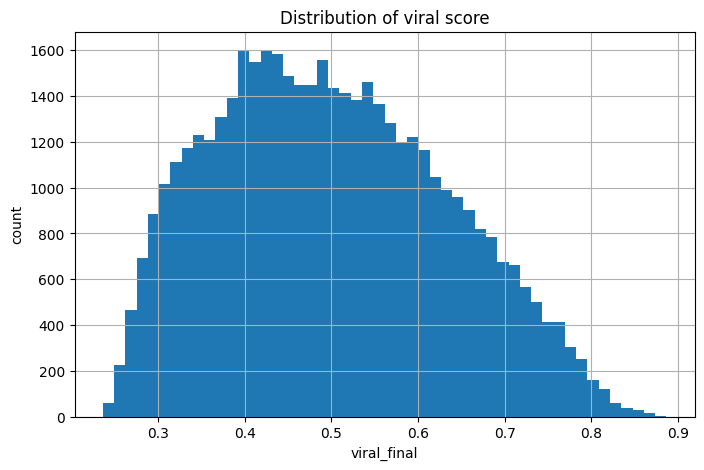

In [67]:
import matplotlib.pyplot as plt


data = feat_filtered.sort_values("viral_final")["viral_final"]

plt.figure(figsize=(8, 5))
plt.hist(data, bins=50)
plt.xlabel("viral_final")
plt.ylabel("count")
plt.title("Distribution of viral score")
plt.grid(True)
plt.show()

In [68]:
import numpy as np
import pandas as pd

def stratified_sample_topic_threshold_bands(
    df: pd.DataFrame,
    N: int,
    score_col: str = "viral_final",
    topic_col: str = "topic",
    thresholds=None,
    seed: int = 42,
    replace_if_needed: bool = True,
):
    rng = np.random.default_rng(seed)
    d = df.copy()
    d = d[d[score_col].notna() & d[topic_col].notna()].copy()

    if thresholds is None:
        thresholds = [
            (0.85, 1.00, 0.70),
            (0.75, 0.85, 0.30),
        ]

    # normalize shares
    total_share = sum(s for _, _, s in thresholds)
    thresholds = [(lo, hi, s / total_share) for lo, hi, s in thresholds]

    # assign band index (0..K-1). Use [lo, hi) except last [lo, hi]
    def assign_band_idx(x: float):
        for i, (lo, hi, _) in enumerate(thresholds):
            if i < len(thresholds) - 1:
                if lo <= x < hi:
                    return i
            else:
                if lo <= x <= hi:
                    return i
        return None

    d["band_id"] = d[score_col].apply(assign_band_idx)
    d = d[d["band_id"].notna()].copy()
    d["band_id"] = d["band_id"].astype(int)

    topics = sorted(d[topic_col].unique())
    n_topics = len(topics)
    if n_topics == 0:
        return d.head(0).copy()

    base = N // n_topics
    rem = N % n_topics
    topic_targets = {t: base + (1 if i < rem else 0) for i, t in enumerate(topics)}

    shares = np.array([s for _, _, s in thresholds], dtype=float)

    out = []
    picked_idx = set()

    # 1) sample within each topic
    for t in topics:
        td = d[d[topic_col] == t]
        tN = topic_targets[t]

        # desired per band within topic
        raw = tN * shares
        counts = np.floor(raw).astype(int)
        residual = tN - counts.sum()
        if residual > 0:
            frac = raw - np.floor(raw)
            for idx in np.argsort(-frac)[:residual]:
                counts[idx] += 1

        cur_parts = []

        for band_i, need in enumerate(counts):
            need = int(need)
            if need <= 0:
                continue

            strata = td[(td["band_id"] == band_i) & (~td.index.isin(picked_idx))]

            if len(strata) >= need:
                take = strata.sample(n=need, replace=False, random_state=int(rng.integers(1e9)))
                cur_parts.append(take)
                picked_idx.update(take.index.tolist())
            else:
                # take all available
                if len(strata) > 0:
                    cur_parts.append(strata)
                    picked_idx.update(strata.index.tolist())

                missing = need - len(strata)
                if missing > 0 and replace_if_needed and len(td[td["band_id"] == band_i]) > 0:
                    # if allowed, fill within topic+band with replacement
                    pool = td[td["band_id"] == band_i]
                    take2 = pool.sample(n=missing, replace=True, random_state=int(rng.integers(1e9)))
                    cur_parts.append(take2)

        cur = pd.concat(cur_parts, axis=0) if cur_parts else td.head(0)

        # fill topic up to tN from same topic (any band)
        if len(cur) < tN:
            need = tN - len(cur)
            extra_pool = td[~td.index.isin(picked_idx)]
            if len(extra_pool) >= need:
                take = extra_pool.sample(n=need, replace=False, random_state=int(rng.integers(1e9)))
                cur = pd.concat([cur, take], axis=0)
                picked_idx.update(take.index.tolist())
            elif replace_if_needed and len(td) > 0:
                take = td.sample(n=need, replace=True, random_state=int(rng.integers(1e9)))
                cur = pd.concat([cur, take], axis=0)

        out.append(cur)

    sample_df = pd.concat(out, ignore_index=False)

    # 2) GLOBAL backfill to reach exactly N (without replacement if possible)
    if len(sample_df) < N:
        need = N - len(sample_df)
        global_pool = d[~d.index.isin(sample_df.index)]
        if len(global_pool) >= need:
            take = global_pool.sample(n=need, replace=False, random_state=int(rng.integers(1e9)))
            sample_df = pd.concat([sample_df, take], axis=0)
        elif replace_if_needed and len(d) > 0:
            take = d.sample(n=need, replace=True, random_state=int(rng.integers(1e9)))
            sample_df = pd.concat([sample_df, take], axis=0)

    # 3) trim if overshoot
    if len(sample_df) > N:
        sample_df = sample_df.sample(n=N, replace=False, random_state=int(rng.integers(1e9)))

    sample_df = sample_df.reset_index(drop=True)
    # label
    labels = {i: f"{int(lo*100)}-{int(hi*100)}" for i, (lo, hi, _) in enumerate(thresholds)}
    sample_df["band_label"] = sample_df["band_id"].map(labels)

    return sample_df


In [69]:
feat_filtered[feat_filtered["viral_final"] >= 0.8].shape

(363, 95)

In [70]:
# Заданные пороги для viral_final
thresholds = [
    (0.70, 1.00, 0.70),  # 70% с viral_final >= 0.85
    (0.0, 0.70, 0.30),  # 30% с viral_final между 0.75 и 0.85
]

# Применение функции
sampled_df = stratified_sample_topic_threshold_bands(
    df=feat_filtered,
    N=300,
    score_col="viral_final",
    topic_col="topic",
    thresholds=thresholds,  # Используем пороговые значения
    seed=42,  # Устанавливаем seed для воспроизводимости
    replace_if_needed=False  # Разрешаем замену в случае нехватки данных
)


In [71]:
sampled_df.shape

(300, 97)

In [72]:
sampled_df.head()

,Unnamed: 0.1,Unnamed: 0,message_id,views_o0,views_o1,views_o2,views_o3,forwards_o0,forwards_o1,forwards_o2,...,viral_final,llm_json,is_economic,topic,confidence,reason,economic_signals,noise_signals,band_id,band_label
0,12438,23745,47b788ec-0a8b-4c12-a498-ca0295056007,22067.0,24449.0,25289.0,25681.0,132.0,137.0,137.0,...,0.762105,"{'confidence': 0.92, 'economic_signals': array...",True,Валютный рынок,0.92,Новость описывает предпочтения граждан получат...,NaN,NaN,0,70-100
1,25884,49049,9369fd65-1b1d-448b-baa1-98d8bb3b4010,12646.0,22410.0,24550.0,25089.0,55.0,83.0,89.0,...,0.713637,"{'confidence': 0.95, 'economic_signals': array...",True,Валютный рынок,0.95,Текст подробно описывает влияние курса доллара...,NaN,NaN,0,70-100
2,41304,78266,ebd6bce8-5a91-4245-91ad-24f4dc0a9872,103203.0,NaN,NaN,NaN,1030.0,NaN,NaN,...,0.783652,"{'confidence': 0.95, 'economic_signals': array...",True,Валютный рынок,0.95,Новость посвящена прогнозу курса доллара к руб...,NaN,NaN,0,70-100
3,31164,59046,b188bd53-6415-41b4-b67a-c1ab0cb817cf,18152.0,29694.0,30578.0,30894.0,105.0,119.0,120.0,...,0.726362,"{'confidence': 0.95, 'economic_signals': array...",True,Валютный рынок,0.95,Текст упоминает разрушение биржевого механизма...,NaN,NaN,0,70-100
4,17380,33128,638595a5-617d-4cbf-b61f-c0e5fe63c8b4,22286.0,28703.0,29929.0,30624.0,215.0,226.0,226.0,...,0.760670,"{'confidence': 0.96, 'economic_signals': array...",True,Валютный рынок,0.96,Текст описывает резкое движение курса доллара ...,NaN,NaN,0,70-100


In [73]:
sampled_df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'message_id', 'views_o0', 'views_o1',
       'views_o2', 'views_o3', 'forwards_o0', 'forwards_o1', 'forwards_o2',
       'forwards_o3', 'reactions_o0', 'reactions_o1', 'reactions_o2',
       'reactions_o3', 'replies_o0', 'replies_o1', 'replies_o2', 'replies_o3',
       'post_uuid', 'id_channel', 'subscribers', 'types_reactions',
       'has_forwards', 'has_reactions', 'has_replies', 'date', 'message',
       'message_vector', 'dayofweek', 'hour', 'has_o0', 'has_o1', 'has_o2',
       'has_o3', 'delta_views_o0', 'delta_views_o1', 'delta_views_o2',
       'delta_views_o3', 'delta_forwards_o0', 'delta_forwards_o1',
       'delta_forwards_o2', 'delta_forwards_o3', 'delta_reactions_o0',
       'delta_reactions_o1', 'delta_reactions_o2', 'delta_reactions_o3',
       'delta_replies_o0', 'delta_replies_o1', 'delta_replies_o2',
       'delta_replies_o3', 'delta_views_per_sub_o0', 'views_per_sub_o0',
       'forwards_per_sub_o0', 'reactions_per_sub_o0', 'ctr_f

In [74]:
sampled_df["topic"].value_counts()

topic
Валютный рынок                            34
Государственная экономическая политика    34
Другое                                    34
Корпоративные финансы                     33
Макроэкономика                            33
Международная торговля                    33
Рынки капитала                            33
Санкции и геополитика                     33
Сырьевые рынки                            33
Name: count, dtype: int64

In [76]:
sampled_df[['message_id', 'id_channel', 'subscribers', 'date', 'message', 'viral_final', 'is_economic', 'topic', 'confidence', 'reason', 'economic_signals',
       'noise_signals', 'band_id', 'band_label']].to_csv("sample2.csv")

In [75]:
sampled_df["message_id"].nunique()

300